# Прогнозирование с помощью регрессии

Для моделирования и прогнозирования работы желтого такси в Нью-Йорке выберем только наиболее активные регионы &ndash; те, в которых среднее количество поездок в час превышает некоторый порог `region_activity_threshold`. Будем прогнозировать количество поездок желтого такси в каждом таком регионе используя 6 отдельных моделей XGBRegressor, каждая из которых строит прогноз на 1-6 часов вперед. Указанный тип модели выбран вследствие его универсальности и мощности. Общая модель работы желтого такси будет представлять собой совокупность шести этих моделей. Для построения используем данные за 1 год с 01.05.2015 по 30.04.2016. Данные за май 2016 будем использовать для оценки качества прогнозирования. Данные за июнь 2016 используем для тестирования модели.

Для работы с регрессорами требуются признаки. Вначале продемонстрируем возможности модели при использовании малого числа групп признаков _(тех, что использовались на прошлой неделе)_. Далее расширим имеющийся набор новыми группами и вновь оценим производительность.

## 1. Предварительная подготовка данных

Будем использовать имеющиеся агрегированные данные о количестве поездок &ndash; таблицу, в индексах строк которой указано время (по часам), а в столбцах указан идентификатор географического региона (ячейки), из которой совершалась поездка.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import time
from datetime import timedelta
import os
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import pickle
from collections import OrderedDict

from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

WEEK_HOURLY = 168
CLUSTERS_DIR = 'cluster_results'
MODELS_DIR   = 'sarimax_models'
DATA_DIR     = 'train_validate_test_data'
SIDES_OF_WORLD = ['w-e', 'n-s']

TRAIN_START_DATETIME    = pd.to_datetime('2015-05-01 00:00:00')
TRAIN_STOP_DATETIME     = pd.to_datetime('2016-04-30 17:00:00')

VALIDATE_START_DATETIME = pd.to_datetime('2016-04-30 23:00:00')
VALIDATE_STOP_DATETIME  = pd.to_datetime('2016-05-31 17:00:00')

TEST_START_DATETIME     = pd.to_datetime('2016-05-31 23:00:00')
TEST_STOP_DATETIME      = pd.to_datetime('2016-06-30 17:00:00')

Populating the interactive namespace from numpy and matplotlib


In [2]:
region_activity_threshold = 5

In [3]:
agg_data = pd.read_csv(
    'agg_data_12plus2.csv', 
    header=0, sep=',', index_col=['hour_bin'], parse_dates=['hour_bin'])
agg_data.head(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
agg_data.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-06-30 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-30 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-30 23:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10248 entries, 2015-05-01 00:00:00 to 2016-06-30 23:00:00
Columns: 2500 entries, 1 to 2500
dtypes: int64(2500)
memory usage: 195.5 MB


In [6]:
activity_check_period = slice(
    VALIDATE_START_DATETIME, 
    VALIDATE_STOP_DATETIME)
regions_means = agg_data[activity_check_period].mean()
low_act_regions_indices = regions_means[regions_means <= region_activity_threshold].index
active_regions_agg_data = agg_data.drop(columns=low_act_regions_indices)
active_regions_agg_data = active_regions_agg_data.transform(lambda x: x.astype(float16), axis=1)
R = active_regions_agg_data.shape[1]
print(u'Всего активных регионов: {}'.format(R))
active_regions_agg_data.head(3)

Всего активных регионов: 102


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,33.0,82.0,33.0,59.0,183.0,377.0,550.0,720.0,913.0,123.0,...,4.0,0.0,6.0,66.0,85.0,142.0,15.0,151.0,31.0,37.0
2015-05-01 01:00:00,18.0,39.0,21.0,59.0,115.0,240.0,310.0,443.0,808.0,89.0,...,14.0,0.0,1.0,1.0,2.0,15.0,6.0,90.0,23.0,32.0
2015-05-01 02:00:00,10.0,17.0,14.0,33.0,71.0,156.0,163.0,342.0,767.0,67.0,...,10.0,0.0,0.0,1.0,1.0,2.0,0.0,28.0,0.0,3.0


In [7]:
active_regions_agg_data.tail(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-06-30 21:00:00,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2016-06-30 22:00:00,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0
2016-06-30 23:00:00,85.0,130.0,86.0,113.0,256.0,428.0,483.0,531.0,631.0,210.0,...,9.0,0.0,7.0,323.0,110.0,147.0,38.0,173.0,119.0,0.0


Далее будем иметь дело только с наиболее активными регионами.

## 2. Малый набор групп признаков.

Малый набор групп регрессионных признаков _(тот, что использовался на прошлой неделе)_, включает в себя три группы признаков.
- 1-я группа &ndash; это почасовые исторические данные за предшествующие 673 часа (примерно месяц).

- 2-я группа &ndash; прогнозы построенных ранее моделей ARIMA. Эти прогнозы предварительно разделены по трем директориям:
    - sarimax_models_k1000_insample_predicts &ndash; это прогнозы периода, на котором обучались модели ARIMA (1 год с 01.05.2015 по 30.04.2016);
    - sarimax_models_k1000_vldt_predicts &ndash; это прогнозы на май 2016 года;
    - sarimax_models_k1000_test_predicts &ndash; это прогнозы за июнь 2016 года.

- 3-я группа &ndash; географические координаты центров регионов. Использовался файл regions.csv, перечисляющий идентификаторы регионов и координаты их границ.

Модели с малым набором групп признаков уже были построены на прошлой неделе. Прогнозы на май 2016 года хранятся в папке (small_set)_regression_vldt_predicts.

Для вычисления ошибки прогнозирования будем использовать функционал:

$$Q_{may}=\frac{1}{R\cdot739\cdot6}\sum_{r=1}^{R}\sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00}\sum_{i=1}^{6}\big\lvert\,\hat{y}_{T{\mid}T+i}^{r}-y_{T+i}^{r}\big\rvert\;.$$

Параметр $R$ показывает количество (активных) географических зон, для которых были построены модели и прогнозы, и определяется порогом `region_activity_threshold` активности зон.

In [8]:
def history_features(region_data, hours):
    periods = list(range(-1,-7,-1)) + list(range(0, hours+1))
    feats = []
    for p in periods:
        feats.append(region_data.shift(p))
    feats = pd.concat(feats, axis=1)
    feats.columns = [str(-p) if p>=0 else '+'+str(-p) for p in periods]
    feats = feats.dropna()

    train    = feats.loc[:TRAIN_STOP_DATETIME]
    validate = feats.loc[VALIDATE_START_DATETIME:VALIDATE_STOP_DATETIME]
    test     = feats.loc[TEST_START_DATETIME:TEST_STOP_DATETIME]
    
    return train, validate, test

In [9]:
def arima_features(region_arima_predicts, arima_indices, history_indices):
    feats = pd.DataFrame(region_arima_predicts)
    feats.index = arima_indices
    feats = feats['ys'].unstack(level=-1)
    feats.reset_index(level=0, inplace=True)
    feats.index = history_indices
    feats.drop(columns='hour', inplace=True)
    feats.columns = [u'ARIMA+'+c for c in feats.columns]
    return feats

In [10]:
def concat_history_arima_features(hfeatures, afeatures):
    features = pd.concat([afeatures, hfeatures], axis=1)
    features = pd.concat(
        [features.iloc[:, 6:12], 
         features.iloc[:, 0:6], 
         features.iloc[:, 12:]], axis=1)
    return features

In [11]:
def geo_centers():
    regions_geo_data = pd.read_csv('regions.csv', header=0, sep=';')
    regions_geo_centers = regions_geo_data['region'].to_frame()
    regions_geo_centers[SIDES_OF_WORLD[0]] = \
        float16((regions_geo_data.west + regions_geo_data.east)/2)
    regions_geo_centers[SIDES_OF_WORLD[1]] = \
        float16((regions_geo_data.south + regions_geo_data.north)/2)
    return regions_geo_centers

In [12]:
def add_geo_features(region, regions_geo_data, data):
    df = pd.DataFrame(data)
    regions_series = regions_geo_data[regions_geo_data.region == int(region)]
    for k in SIDES_OF_WORLD:
        df[k] = regions_series[k].values[0]
    return df

In [13]:
def q_error(output_dir, predict_col='predict', history_col='history'):
    predicts = {
        f_name.split('_')[1] : pd.read_csv('{}\{}'.format(output_dir, f_name), index_col=0) 
        for f_name in os.listdir(output_dir)}
    q_coef = sum([len(p) for p in predicts.values()])
    predicts_errors = {}
    for shift, predict in predicts.items():
        predicts_errors[shift] = sum(abs(predict[predict_col] - predict[history_col]))
    return round(sum(predicts_errors.values()) / q_coef, 5)

In [14]:
q_small_set = q_error(
    output_dir='(small_set)_regression_vldt_predicts', predict_col='predict', history_col='history')
print('Ошибка при малом наборе групп признаков: {}'.format(q_small_set))

Ошибка при малом наборе групп признаков: 15.87637


## 3. Расширенный набор групп признаков.

Добавим к имеющимся группам признаков еще несколько:
- 4-ая группа &ndash; скользящие средние по количеству поездок за некоторое количество предшествующих часов, название признака начинается с `ma`;
- 5-ая группа &ndash; подсчет количества людей, покинувших такси в данном регионе, и, наоборот, взявших такси в нем (`dropoff` и `pickup`); эти данные содержатся в заранее подготовленных файлах passengers_dropoff_data.csv и passengers_pickup_data.csv;
- 6, 7 и 8-ая группы &ndash; средние значения количества поездок, покинувших и взявших такси пассажиров в данный час на временных промежутках усреднения некоторой длины (`trips_mean`, `dropoff_mean` и `pickup_mean`);
- 9, 10 и 11 группы &ndash; похожи на предыдущие три группы, однако усреднение учитывает не только время суток (час), но и день недели (`trips_wdmean`, `dropoff_wdmean` и `pickup_wdmean`);
- 12 группа &ndash; добавляет значения признаков `trips_wdmean` из группы 9 тех регионов, которые проявляют наибольшее сходство с данным регионом (`similar`).

In [15]:
def add_movav_features(history_data, windows, data):
    mov_avs = []
    for w in windows:
        ma = history_data.rolling(window=w).mean()
        ma.name = 'ma_{}'.format(w)
        mov_avs.append(ma)
    return pd.concat([data]+mov_avs, join='inner', axis=1)

In [16]:
passengers_pickup_data = pd.read_csv(
    'passengers_pickup_data.csv', 
    header=0, sep=',', index_col=['hour_bin'], parse_dates=['hour_bin'])
passengers_pickup_data.head(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,58.0,134.0,53.0,106.0,296.0,658.0,883.0,1180.0,1478.0,206.0,...,8.0,0.0,8.0,97.0,131.0,266.0,30.0,249.0,54.0,62.0
2015-05-01 01:00:00,34.0,67.0,39.0,81.0,171.0,446.0,538.0,720.0,1340.0,155.0,...,18.0,0.0,5.0,1.0,2.0,22.0,11.0,154.0,29.0,52.0
2015-05-01 02:00:00,17.0,19.0,35.0,70.0,122.0,272.0,269.0,570.0,1271.0,119.0,...,12.0,0.0,0.0,1.0,1.0,2.0,0.0,55.0,0.0,3.0


In [17]:
passengers_dropoff_data = pd.read_csv(
    'passengers_dropoff_data.csv', 
    header=0, sep=',', index_col=['hour_bin'], parse_dates=['hour_bin'])
passengers_dropoff_data.head(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,132.0,285.0,77.0,138.0,440.0,437.0,420.0,614.0,913.0,195.0,...,45.0,1.0,9.0,3.0,15.0,4.0,0.0,0.0,0.0,1.0
2015-05-01 01:00:00,53.0,166.0,28.0,71.0,267.0,265.0,319.0,438.0,625.0,108.0,...,63.0,0.0,1.0,3.0,5.0,0.0,0.0,6.0,0.0,0.0
2015-05-01 02:00:00,59.0,112.0,27.0,58.0,178.0,155.0,160.0,218.0,410.0,81.0,...,44.0,0.0,6.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0


In [18]:
def add_passengers_count_features(passengers_region_data, data):
    pickup_data, dropoff_data = passengers_region_data
    pickup_data.name, dropoff_data.name = 'pickup', 'dropoff'
    return pd.concat([data, pickup_data, dropoff_data], axis=1)[data.index[0]:data.index[-1]]

In [19]:
def add_means_features(
        region_data, mean_period=WEEK_HOURLY, result_period=24, name='', data=None):
    return means_features(
        region_data, mean_period, result_period, name, data, 
        feats_list=['hour'], left_on='hour')

def add_weekday_means_features(
        region_data, mean_period=WEEK_HOURLY*4, result_period=WEEK_HOURLY, name='', data=None):
    return means_features(
        region_data, mean_period, result_period, name, data, 
        feats_list=['hour', 'weekday'], left_on=['weekday', 'hour'])

def means_features(
        region_data, mean_period, result_period, name, data, 
        feats_list, left_on):
    
    region_data = pd.DataFrame(region_data)
    for f in feats_list:
        region_data[f] = getattr(region_data.index, f)
    stop = data.index[-1]
    start = stop - timedelta(hours=mean_period-1)

    means = []
    while True:
        means_index = region_data.loc[stop-timedelta(hours=result_period-1):stop].index
        means_dict = {f:getattr(means_index, f) for f in feats_list}
        dates_to_hours = pd.DataFrame(data=means_dict, index=means_index)
        hourly_means = region_data.loc[start:stop].groupby(by=feats_list[::-1]).mean()
        hourly_means = pd.merge(
            dates_to_hours, hourly_means, left_on=left_on, right_index=True)
        hourly_means = hourly_means.iloc[:,-1]
        means.append(hourly_means)
        stop -= timedelta(hours=result_period)
        start = stop - timedelta(hours=mean_period-1)
        if (start < region_data.index[0]) or (stop < data.index[0]): break
    means = pd.concat(means).sort_index()

    shifted = [means]
    for _ in range(1,7):
        sh = shifted[-1].shift(-1)
        sh.iloc[-1] = sh.iloc[-result_period-1]
        shifted.append(sh)
    shifted = pd.concat(shifted, axis=1)
    shifted.columns = ['{}_+{}'.format(name,i) for i in range(0,7)]
    shifted = shifted.iloc[:, 1:]

    start, stop = data.index[0], data.index[-1]
    return pd.concat([data, shifted[start:stop]], axis=1)

In [20]:
def main_features_adder(feats, funcs_with_args):
    feats = pd.DataFrame(feats)
    for func, args in funcs_with_args:
        args['data'] = feats
        feats = func(**args)
    return feats

def features(
        region_data, region_arima_predicts, arima_indices, region, regions_geo_data, historical_hours, 
        passengers_region_data, feats_adders_with_args, 
        all_regions_train_vldt_test_shifts=[None]*3, similar_regions=None):
        
    pickup_data, dropoff_data = passengers_region_data
    train_vldt_test = []
    for (_, preds, indices, history_feats, all_regions_shifts) in zip(
            ['train', 'validate', 'test'], 
            region_arima_predicts, 
            arima_indices, 
            history_features(region_data, historical_hours), 
            all_regions_train_vldt_test_shifts):
        
        arima_feats = arima_features(preds, indices, history_feats.index)
        feats = concat_history_arima_features(history_feats, arima_feats)
        funcs_with_args = eval(feats_adders_with_args)
        feats = main_features_adder(feats, funcs_with_args)
        train_vldt_test.append(feats)

    return train_vldt_test

In [21]:
def arima_insample_predicts(arima_insample_predicts, region, hours):
    start = TRAIN_START_DATETIME + timedelta(hours=hours)
    cut_index = '{}_{}_{}_1'.format(region, str((start).date()), str(start.hour))
    return arima_insample_predicts[region].loc[cut_index:]

def stack_data(
        regions_history, 
        arima_insample_predicts_full, arima_vldt_predicts, arima_test_predicts, 
        arima_indices, regions_geo_data, hours, passengers_region_data, 
        feats_adders_with_args, 
        all_regions_train_vldt_test_shifts=[None]*3, similar_regions=None):
    
    trains, validates, tests = [], [], []
    train_str_index, validate_str_index, test_str_index = [], [], []
    
    regions_features = {}
    
    for region in regions_history:
        region_data = regions_history[region]
        region_arima_vldt_predicts = arima_vldt_predicts[region]
        region_arima_test_predicts = arima_test_predicts[region]
        region_arima_predicts = \
            arima_insample_predicts(arima_insample_predicts_full, region, hours), \
            region_arima_vldt_predicts, \
            region_arima_test_predicts
        train, validate, test = features(
            region_data, 
            region_arima_predicts, 
            arima_indices, 
            region, 
            regions_geo_data, 
            hours, 
            passengers_region_data, 
            feats_adders_with_args, 
            all_regions_train_vldt_test_shifts, 
            similar_regions)
        
        regions_features[region] = train, validate, test
        
        index_to_str = lambda x: '{}_{}_{}'.format(region, x.date(), x.hour)
        train_str_index += map(index_to_str, train.index)
        validate_str_index += map(index_to_str, validate.index)
        test_str_index += map(index_to_str, test.index)
        
        trains.append(train)
        validates.append(validate)
        tests.append(test)
        
    trains = pd.concat(trains)
    validates = pd.concat(validates)
    tests = pd.concat(tests)
    
    return \
        (trains, validates, tests, train_str_index, validate_str_index, test_str_index), \
        regions_features

In [22]:
def arima_predicts(arima_predicts_dir):
    return {
        f_name.split('_')[1] : \
        pd.read_csv('{}\{}'.format(arima_predicts_dir, f_name), index_col=0) 
        for f_name in os.listdir(arima_predicts_dir)}

In [23]:
def transform_index(index):
    idx = \
        map(lambda x: ('_'.join(x[1:-1]), x[-1]), 
            map(lambda x: ['{:02d}'.format(int(e)) if i == 2 else e for i, e in enumerate(x)], 
                map(lambda x: x.split('_'), index)))
    return pd.MultiIndex.from_tuples(idx, names=['hour', 'shift'])

In [24]:
def split_for_shift(train, shift, features_selections):
    train_x = train.iloc[:, 6:]
    train_y = train.iloc[:, shift-1]

    if type(features_selections) != type(None):
        feats_names = train_x.columns
        selected_feats = feats_names[features_selections[shift-1].get_support()]
        train_x = train_x[selected_feats.union(SIDES_OF_WORLD)]
    
    return train_x, train_y

In [25]:
def models_for_features_selection(train, shifts=range(1,7), verbose=True, features_selections=None):
    models = []
    for shift in shifts:
        if verbose: print('Модель со смещением в {} ч.'.format(shift))
        train_x, train_y = split_for_shift(train, shift, features_selections)
        model = XGBRegressor()
        model.fit(train_x, train_y)
        models.append(model)
        if verbose:
            fig, ax = plt.subplots(figsize=(18,60))
            plot_importance(model, ax=ax)
            pyplot.show()
    return models

In [26]:
region = '1327' ### центр самого крупного кластера

historical_hours = WEEK_HOURLY*4

arima_insample_predicts_dir = 'sarimax_models_k1000_insample_predicts'
arima_insample_predicts_full = arima_predicts(arima_insample_predicts_dir)
region_arima_insample_predicts = arima_insample_predicts(
    arima_insample_predicts_full, region, historical_hours)
arima_insample_indices = transform_index(region_arima_insample_predicts.index)

arima_vldt_predicts_dir = 'sarimax_models_k1000_vldt_predicts'
arima_vldt_predicts = arima_predicts(arima_vldt_predicts_dir)
region_arima_vldt_predicts = arima_vldt_predicts[region]
arima_vldt_indices = transform_index(region_arima_vldt_predicts.index)

arima_test_predicts_dir = 'sarimax_models_k1000_test_predicts'
arima_test_predicts = arima_predicts(arima_test_predicts_dir)
region_arima_test_predicts = arima_test_predicts[region]
arima_test_indices = transform_index(region_arima_test_predicts.index)

arima_indices = arima_insample_indices, arima_vldt_indices, arima_test_indices
regions_geo_centers = geo_centers()

passengers_region_data = passengers_pickup_data[region], passengers_dropoff_data[region]

Для получения признаков последней 12-й группы построим вначале модели XGBRegressor для каждого региона, выбирая в качестве признаков таких моделей усредненные с учетом дня недели количества поездок в каждый час, совершенные из всех остальных регионов, кроме одного &ndash; того, для которого строится регрессор.

Для удобства модели уже построены и сохранены в папку region_to_regions_models.

Будем считать, что самые важные признаки указывают на регионы, схожие с моделируемым регионом. Признаки, связанные с выбранными таким образом регионами включим в 6 моделей.

In [27]:
def region_to_regions(regions_features, region, historical_hours, train_vldt_test_index):
    region_y_data = \
        regions_features[region][train_vldt_test_index].iloc[:, 0:6]
    other_regions = set(regions_features.keys()).difference(set([region]))
    return get_region_to_regions_data(
        regions_features, historical_hours, 
        region_y_data, other_regions, train_vldt_test_index)

def all_shifts(regions_features, historical_hours, train_vldt_test_index):
    region_y_data = pd.DataFrame()
    other_regions = regions_features.keys()
    return get_region_to_regions_data(
        regions_features, historical_hours, 
        region_y_data, other_regions, train_vldt_test_index)

def get_region_to_regions_data(
        regions_features, historical_hours, 
        region_y_data, other_regions, train_vldt_test_index):
    u"""
    train_vldt_test_index=0 - для данных обучения, 1 - для валидационных данных, 2 - тестовые данные.
    """
    regions_data = []
    for other_region in other_regions:
        region_x_data = \
            regions_features[other_region][train_vldt_test_index].iloc[:, 13+historical_hours:]
        region_x_data.columns = ['{}~{}'.format(c,other_region) for c in region_x_data.columns]
        regions_data.append(region_x_data)
    return pd.concat([region_y_data]+regions_data, axis=1)

In [28]:
def save_models_with_feats(models, region, feats, output_dir, shifts):
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    for model, shift in zip(models, shifts):
        filename = 'rtors_shift{}_{}.pkl'.format(shift, region)
        pickle.dump((model, feats), open('{}\\{}'.format(output_dir, filename), 'wb'))

In [29]:
def build_rotrs_models(regions_features, historical_hours, verbose='(n%10==0)|(n==1)'):
    shifts = [1]
    for n, region in enumerate(regions_features, 1):
        if verbose != 'False' : print('{}.\nИсследуется регион {}'.format(n,region))
        r_to_rs_data = region_to_regions(
            regions_features, region, historical_hours, train_vldt_test_index=0)
        rtors_feats_names = r_to_rs_data.columns.values[6:]
        r_to_rs_models_for_feats_select = models_for_features_selection(
            r_to_rs_data, shifts=shifts, verbose=eval(verbose))
        save_models_with_feats(
            r_to_rs_models_for_feats_select, 
            region, 
            rtors_feats_names, 
            output_dir='region_to_regions_models', 
            shifts=shifts)

In [30]:
rtors_feats_descriptor = \
"""[(add_weekday_means_features, 
    {'region_data'   : region_data, 
     'mean_period'   : WEEK_HOURLY*4, 
     'result_period' : WEEK_HOURLY, 
     'name'          : 'trips_wdmean'})]"""

_, regions_features = stack_data(
    active_regions_agg_data, 
    arima_insample_predicts_full, 
    arima_vldt_predicts, 
    arima_test_predicts, 
    arima_indices, 
    regions_geo_centers, 
    historical_hours, 
    passengers_region_data, 
    rtors_feats_descriptor)

In [31]:
build_rotrs_models(regions_features, historical_hours, verbose='False')

Диаграмма важности признаков, использованных при построении модели одного из регионов (1783), приведена ниже в виде рисунка.

![title](rtors_1783_diag.png)

Из диаграммы видно, что признаки `trips_wdmean`, построенные по данным регионов 1734 и 1684 оказались наиболее важными при построении модели региона 1783. Поэтому, для региона 1783 подобные признаки будут включены в 12-ю группу признаков. И так для каждого региона. Выбранные таким образом данные в своей совокупности образуют признак `similar`.

Модели всех регионов построены заранее и хранятся в папке region_to_regions_models, откуда и будут загружены.

In [32]:
def load_rtors_models(rtors_models_dir):
    rtors_models = {}
    for _, rtors_models_filename in enumerate(os.listdir(rtors_models_dir), 1):
        region = rtors_models_filename.split('_')[2].split('.')[0]
        filename = '{}\\{}'.format(rtors_models_dir, rtors_models_filename)
        rtors_models[region] = pickle.load(open(filename, 'rb'))
    return rtors_models

In [33]:
def most_similar_regions(rtors_models_dir, most_similar_regions_num):
    rtors_models = load_rtors_models(rtors_models_dir)
    most_similar_regs = {}
    for region, (model, feats) in rtors_models.items():
        d = dict(zip(feats, model.feature_importances_))
        best_feats = OrderedDict(
            sorted(d.items(), key=lambda t: t[1], reverse=True)).keys()
        regions = [f.split('~')[1] for f in best_feats]
        similar_regions = []
        regions_iter = iter(regions)
        while len(similar_regions) < most_similar_regions_num:
            r = next(regions_iter)
            if r not in similar_regions:
                similar_regions.append(r)
        most_similar_regs[region] = similar_regions
    return most_similar_regs

In [34]:
all_regions_train_vldt_test_shifts = \
    [all_shifts(regions_features, historical_hours, index) for index in range(3)]

similar_regions = most_similar_regions(
    rtors_models_dir='region_to_regions_models', most_similar_regions_num=4)

In [35]:
def add_similar_regions_features(all_regions_shifts, similar_regions, region, data):
    shifts = range(1,7)
    feats = []
    new_feats_names = []
    for n, r in enumerate(similar_regions[region], 1):
        feats += ['trips_wdmean_+{}~{}'.format(shift, r) for shift in shifts]
        new_feats_names += ['similar_+{}~{}'.format(shift, n) for shift in shifts]
    similar_regions_feats = all_regions_shifts[feats]
    similar_regions_feats.columns = new_feats_names
    return pd.concat([data, similar_regions_feats, ], axis=1)

## 4. Отбор регрессионных признаков.

Для отбора из всех групп наиболее значимых регрессионных признаков построим вначале модели прогнозирования на 1-6 часов вперед одного &laquo;среднего&raquo; региона. В качестве такового выберем регион с идентификатором 1327. Этот регион является центром самого большого кластера регионов. Исследования кластеров проводились при построении моделей ARIMA.

In [36]:
all_feats_descriptor = \
"""[(add_geo_features, {'region' : region, 'regions_geo_data' : regions_geo_data}), 
    (add_movav_features , {'history_data' : region_data, 'windows' : [8,24,WEEK_HOURLY]}), 
    (add_passengers_count_features , {'passengers_region_data' : passengers_region_data}), 
    (add_means_features , 
     {'region_data' : region_data, 
      'mean_period' : 168, 
      'result_period' : 24,  
      'name' : 'trips_mean'}), 
    (add_means_features , 
     {'region_data' : pickup_data, 
      'mean_period' : 168, 
      'result_period' : 24,  
      'name' : 'pickup_mean'}), 
    (add_means_features , 
     {'region_data' : dropoff_data, 
      'mean_period' : 168, 
      'result_period' : 24,  
      'name' : 'dropoff_mean'}), 
    (add_weekday_means_features , 
     {'region_data' : region_data, 
      'mean_period' : 672, 
      'result_period' : 168, 
      'name' : 'trips_wdmean'}), 
    (add_weekday_means_features , 
     {'region_data' : pickup_data, 
      'mean_period' : 672, 
      'result_period' : 168, 
      'name' : 'pickup_wdmean'}), 
    (add_weekday_means_features , 
     {'region_data' : dropoff_data, 
      'mean_period' : 672, 
      'result_period' : 168, 
      'name' : 'dropoff_wdmean'}), 
    (add_similar_regions_features , 
     {'all_regions_shifts' : all_regions_shifts, 
      'similar_regions' : similar_regions, 
      'region' : region})]"""

In [37]:
region = '1327'
train, _, _ = features(
    region_data=active_regions_agg_data[region], 
    region_arima_predicts=(
        region_arima_insample_predicts,
        region_arima_vldt_predicts,
        region_arima_test_predicts), 
    arima_indices=arima_indices, 
    region=region, 
    regions_geo_data=regions_geo_centers, 
    historical_hours=historical_hours, 
    passengers_region_data=passengers_region_data, 
    feats_adders_with_args=all_feats_descriptor, 
    all_regions_train_vldt_test_shifts=all_regions_train_vldt_test_shifts, 
    similar_regions=similar_regions)

Модель со смещением в 1 ч.


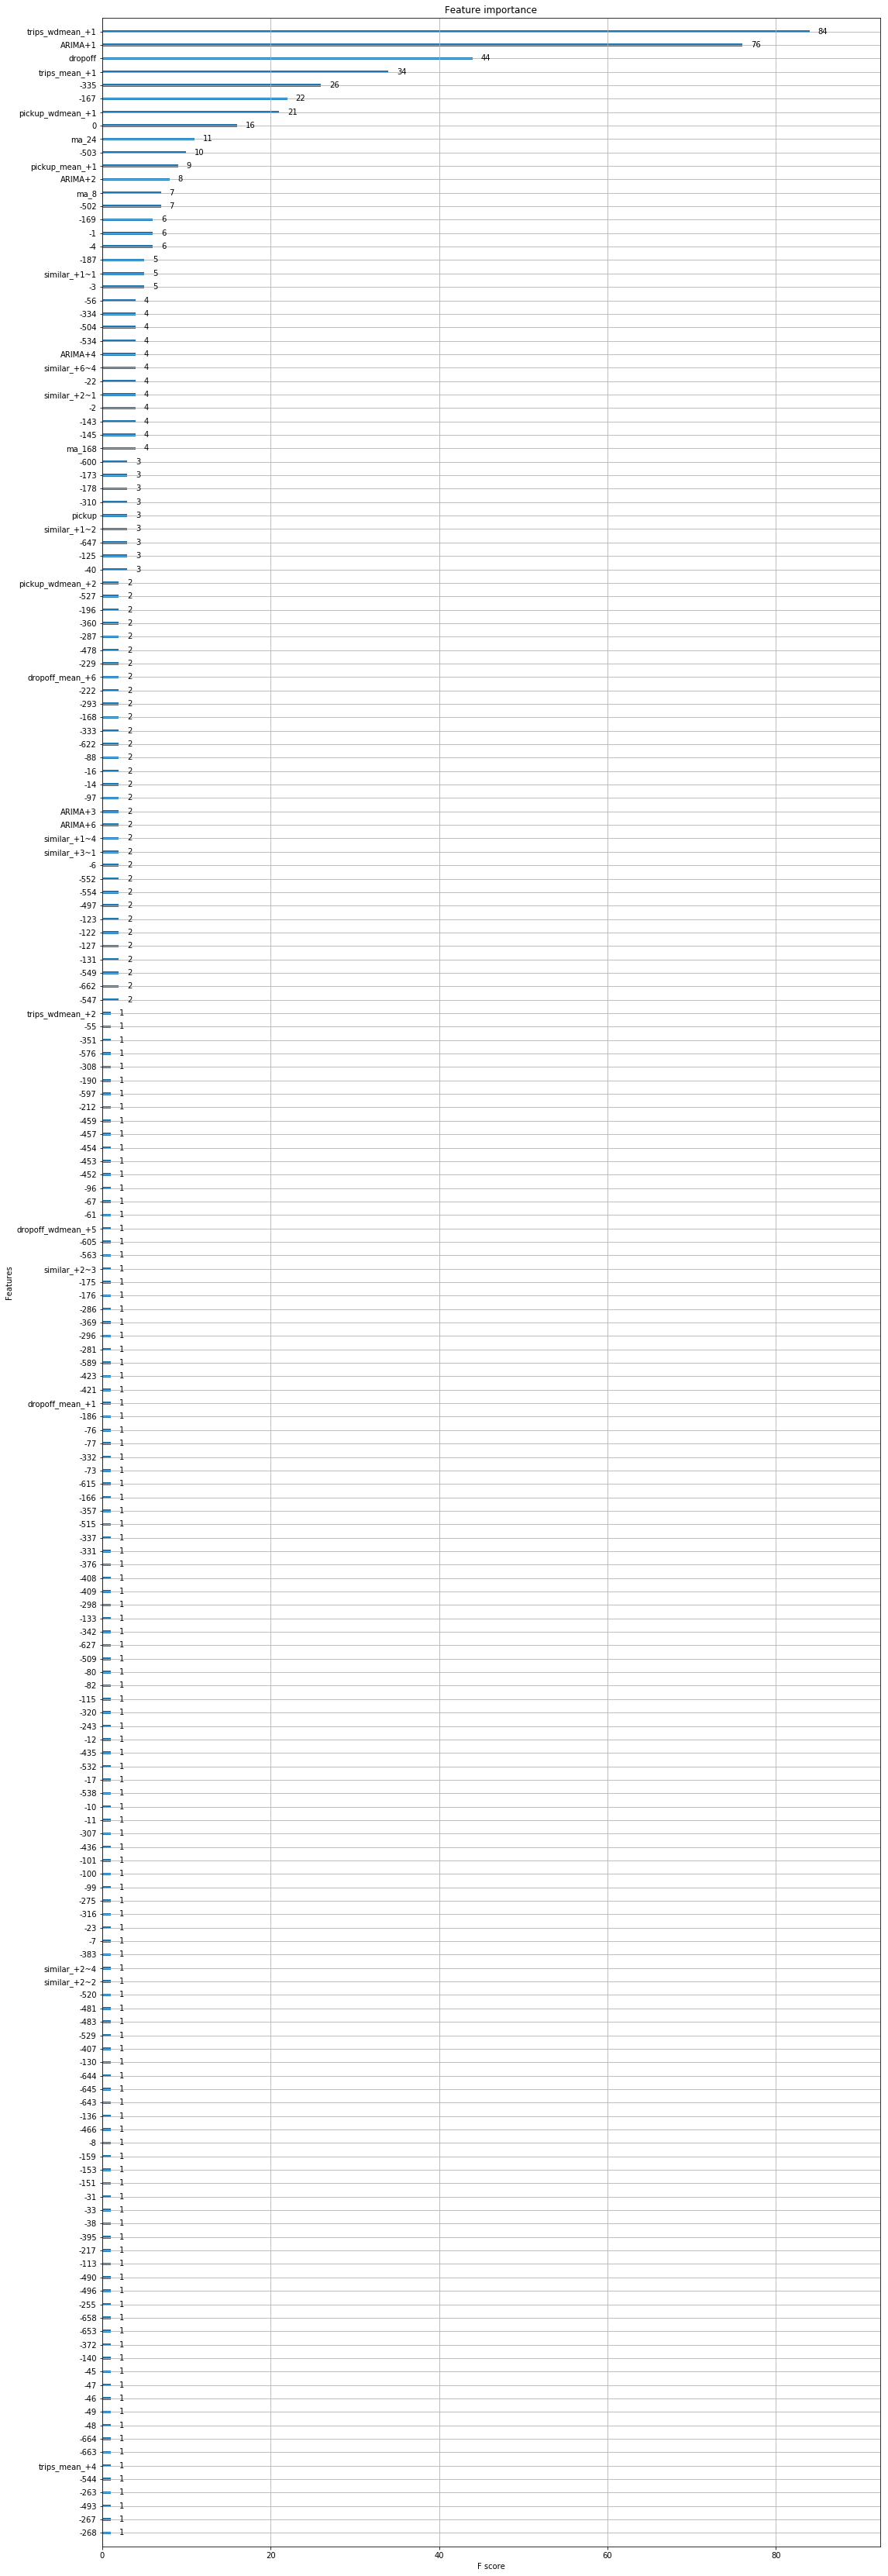

Модель со смещением в 2 ч.


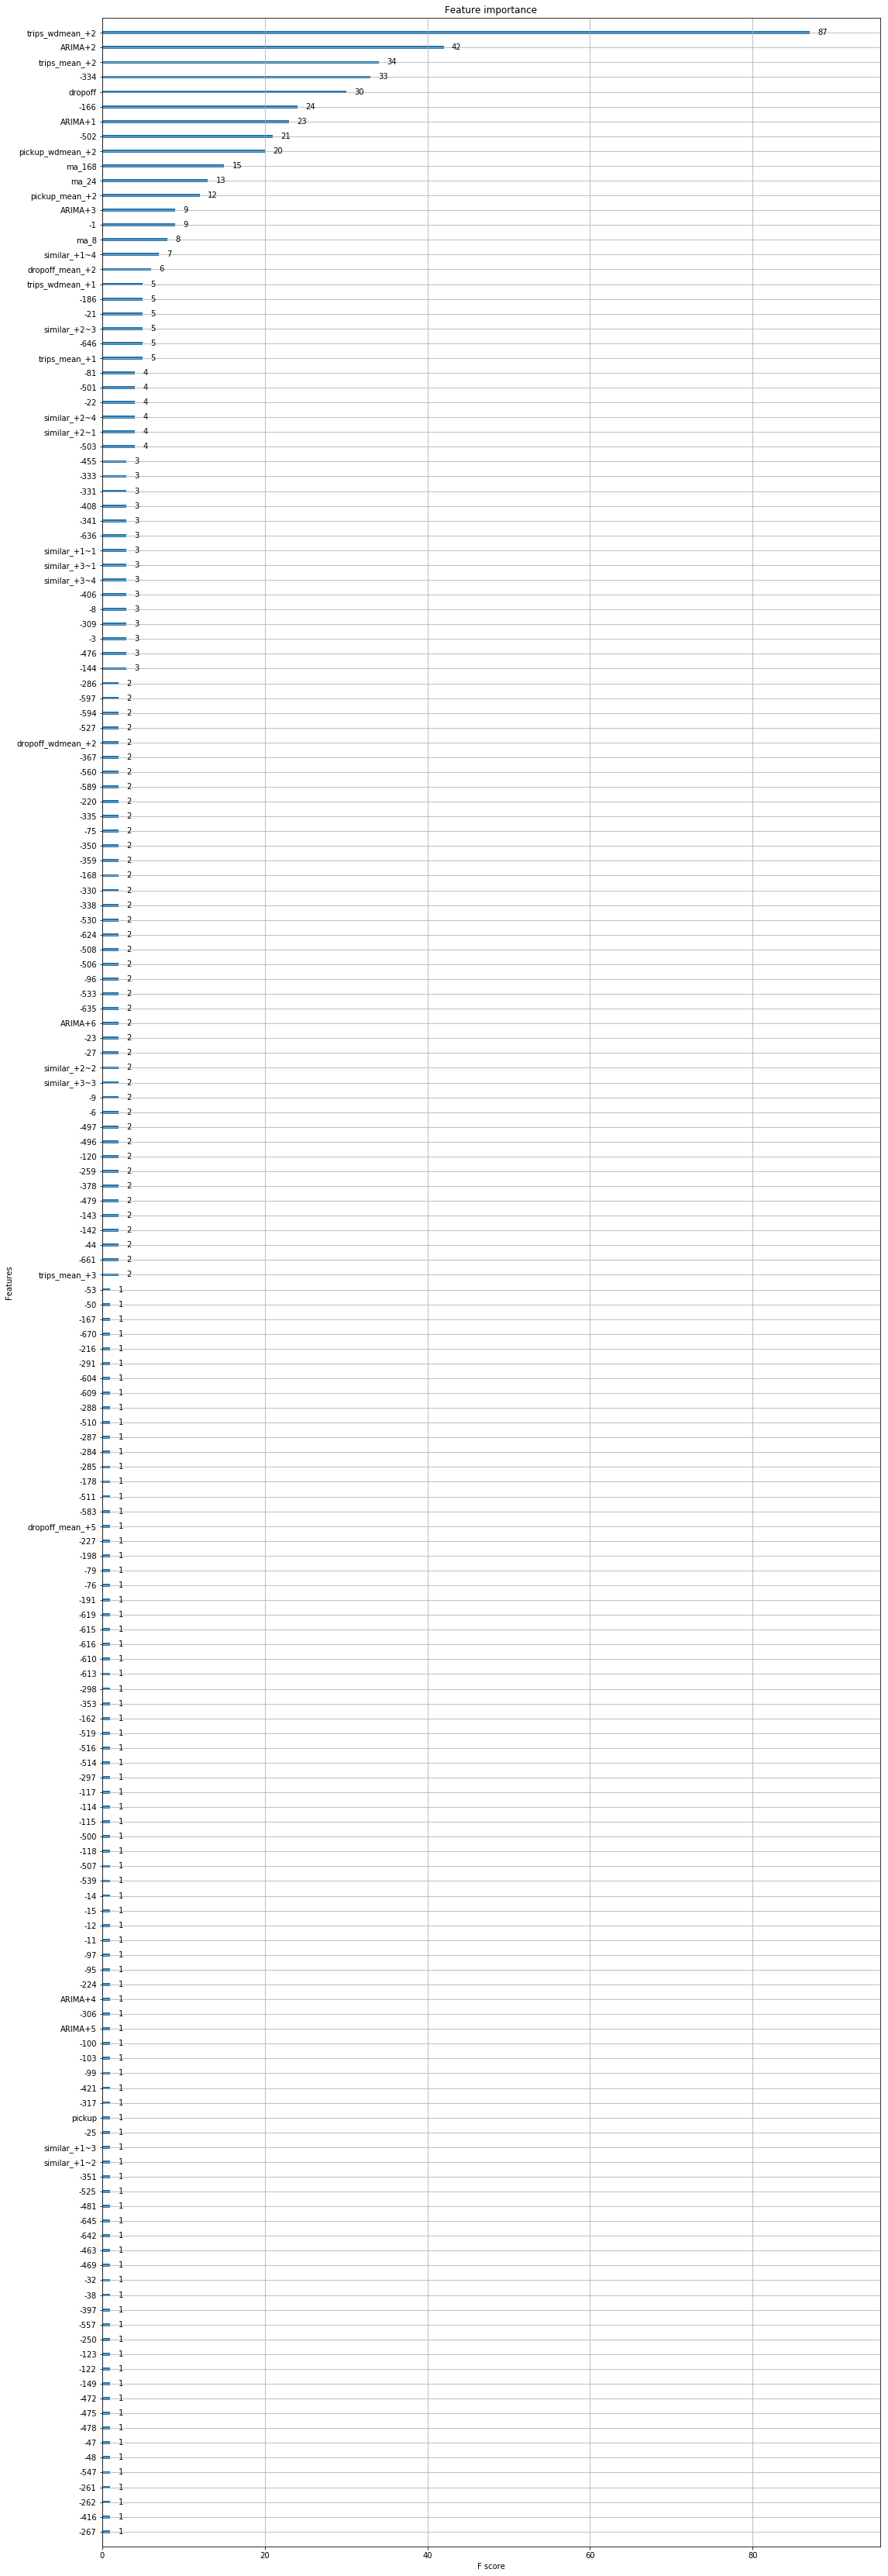

Модель со смещением в 3 ч.


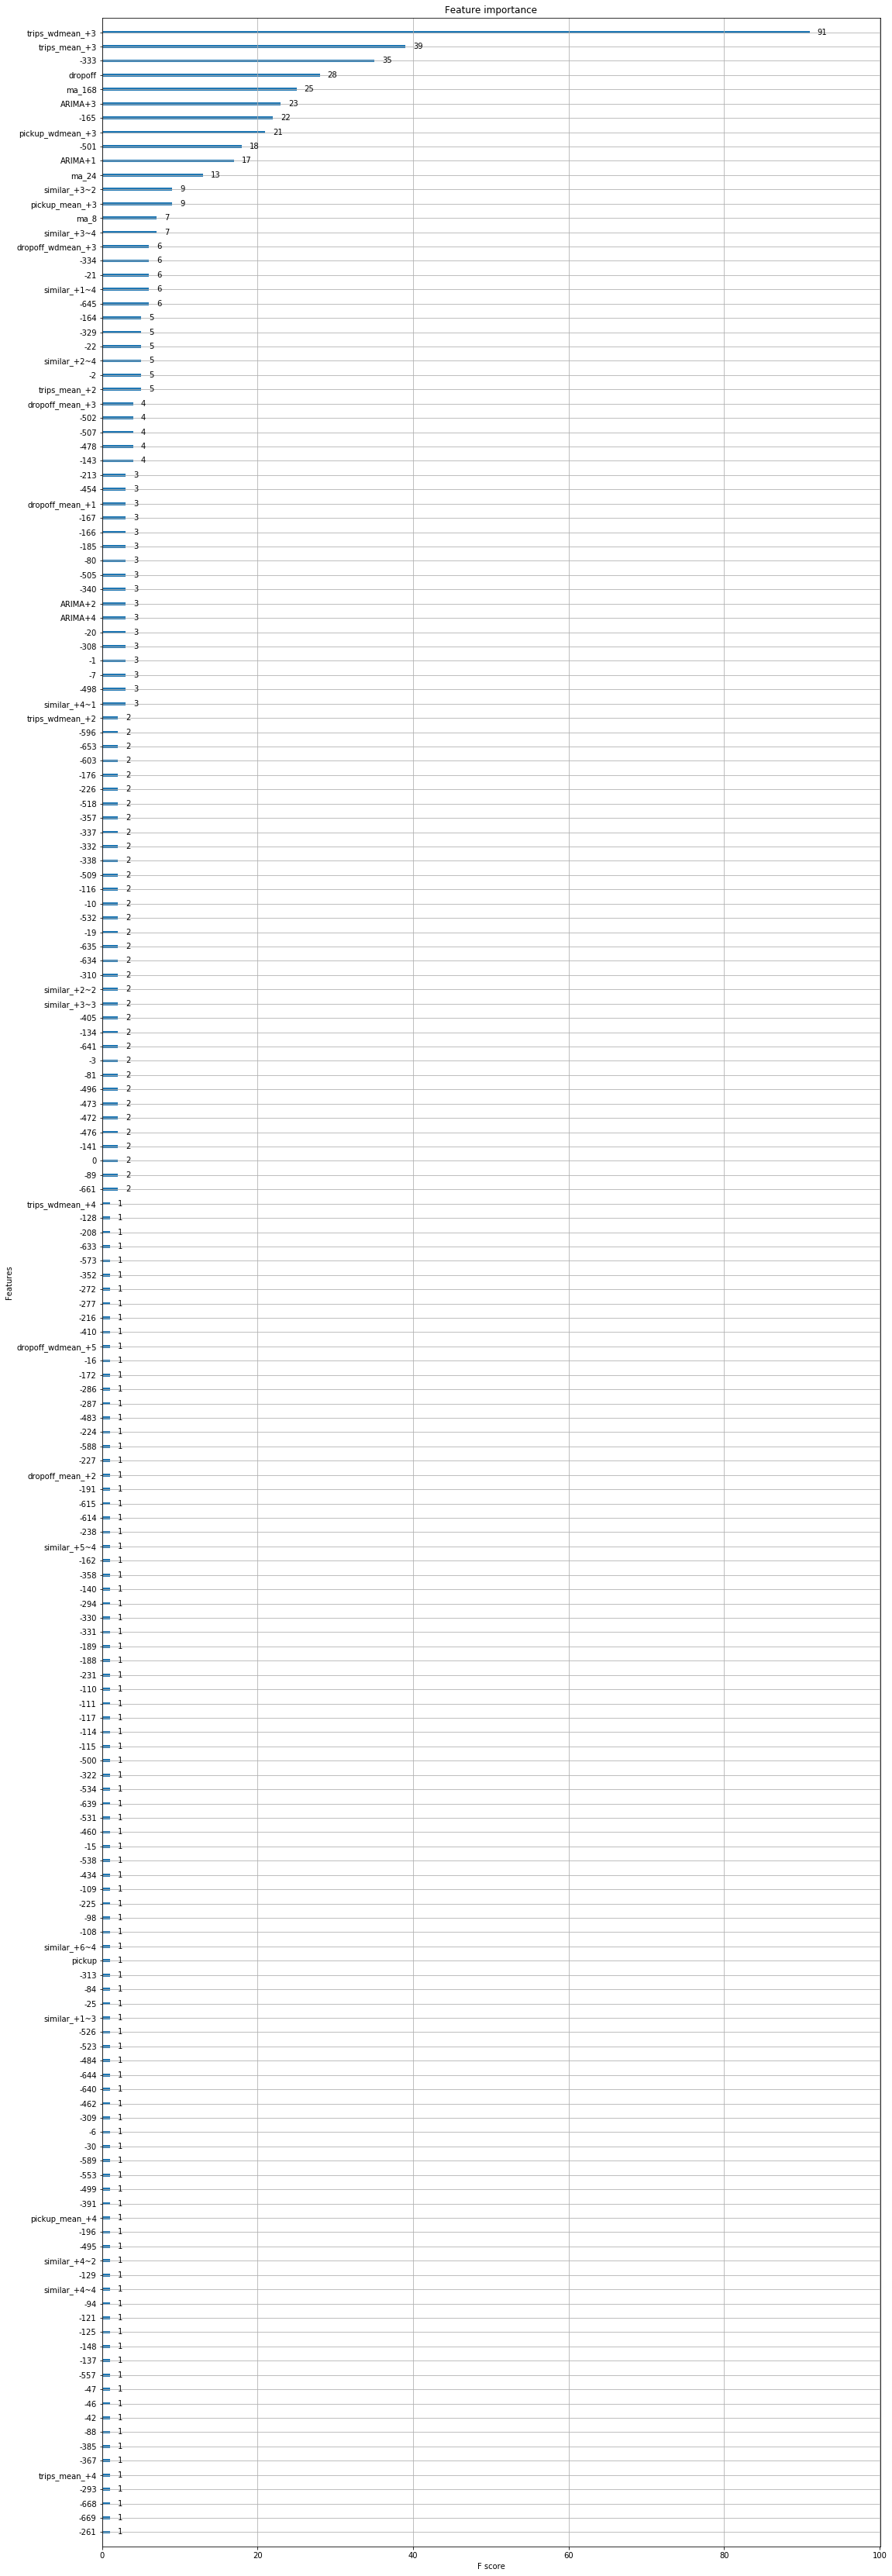

Модель со смещением в 4 ч.


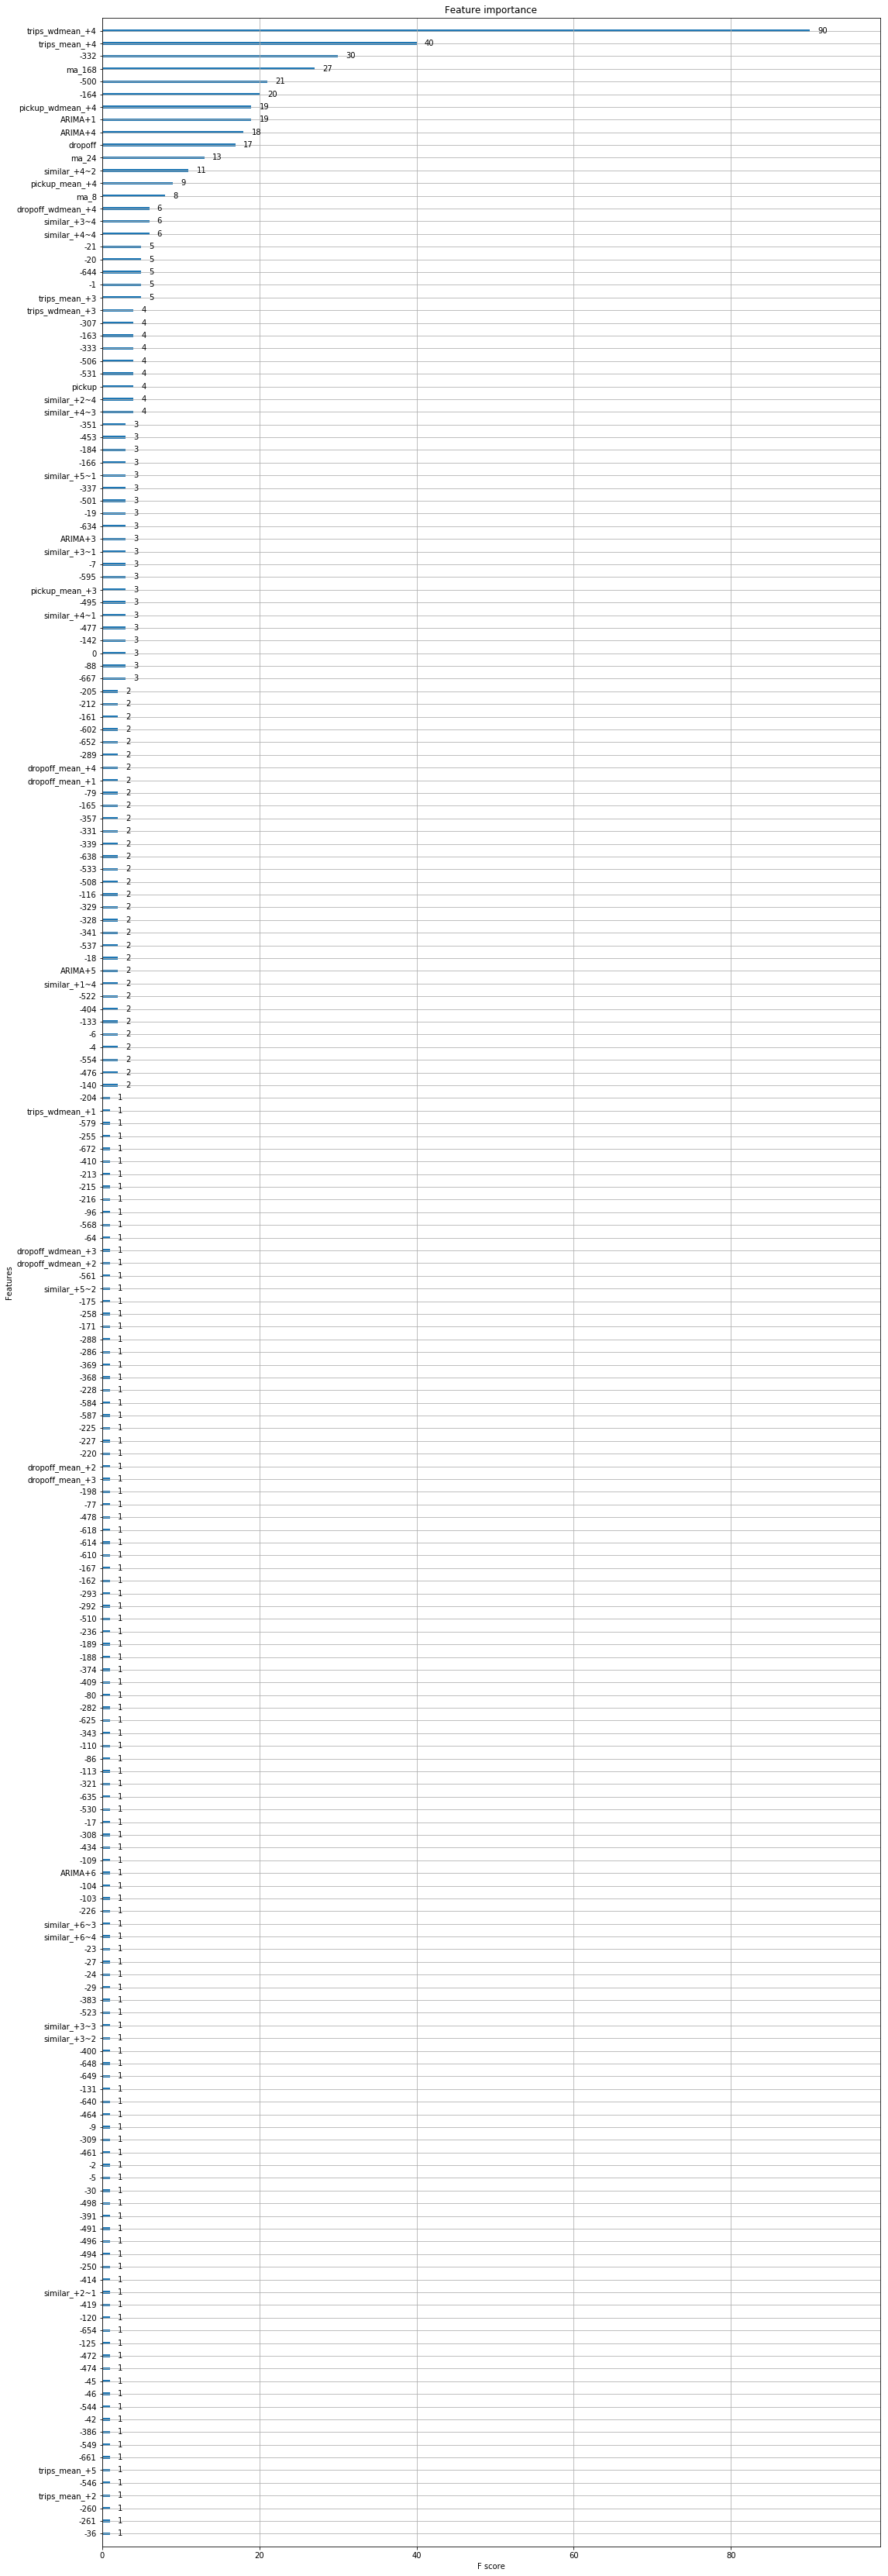

Модель со смещением в 5 ч.


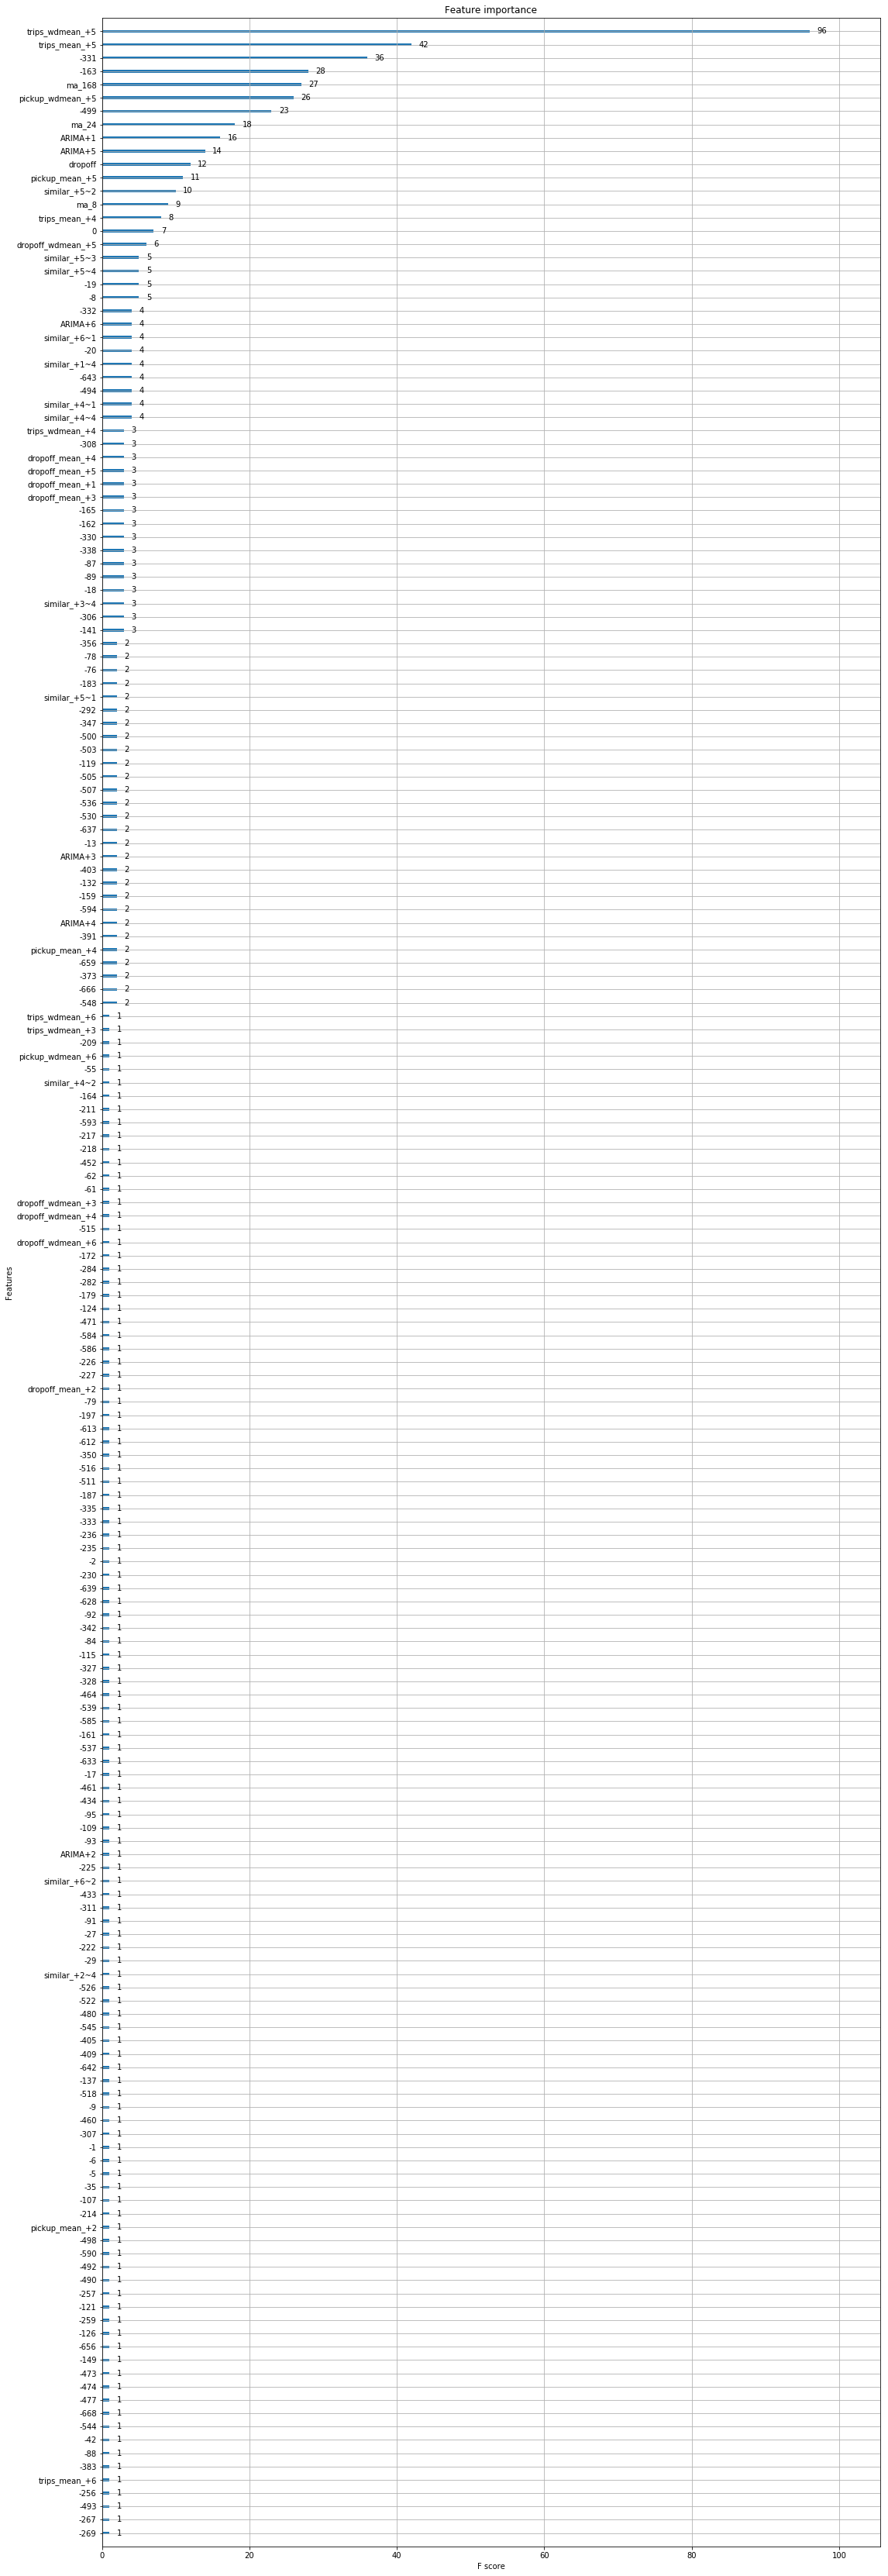

Модель со смещением в 6 ч.


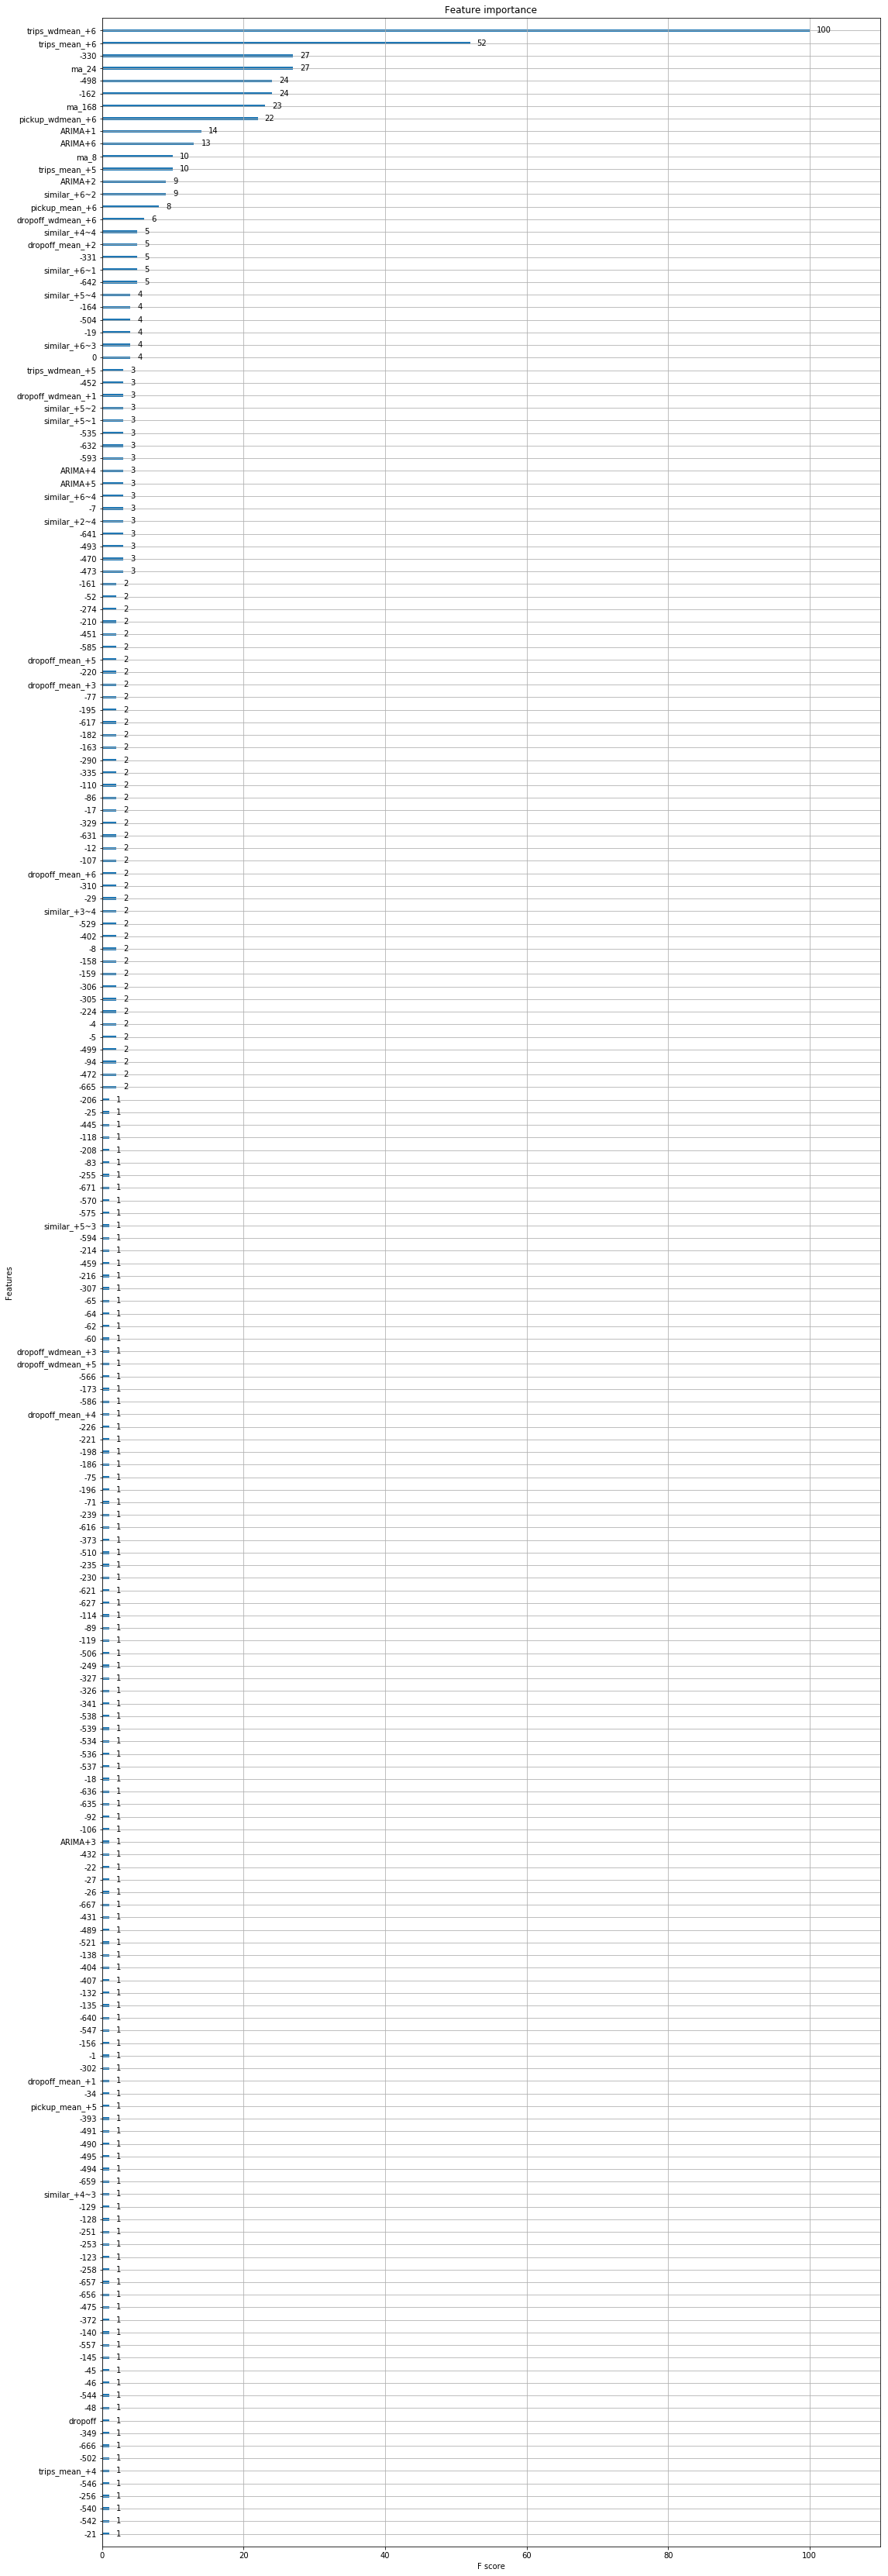

In [38]:
models_for_feats_select = models_for_features_selection(train)

Можно обратить внимание, что для каждой из 6 построенных &laquo;однорегионных&raquo; моделей самым значимым признаком оказался признак trips_wdmean того же смещения, что и построенная модель.

Далее для обучения, валидации и тестирования каждой из 6 &laquo;всерегионных&raquo; моделей  будем использовать выборки, получаемые из общей выборки путем отбора только самых важных для строящейся модели признаков.

Отбор будем осуществлять с помощью установки значения параметра `threshold` функции `features_selector` &ndash; чем выше значение, тем значимее признаки отбираются. Таким признакам соответствуют верхние строки показанных диаграмм. Более низкие значения параметра увеличивают количество отобранных признаков. Параметр `threshold` будем считать гиперпараметром общей модели.

In [39]:
def features_selector(models, threshold):
    return [SelectFromModel(model, threshold=threshold, prefit=True) for model in models]

## 5. Построение моделей, прогнозирование, выбор гиперпараметров.

При построении общих моделей и поиске оптимальной среди них, используем следующие гиперпараметры:
- порог важности признаков `threshold`, регулирует количество регрессионных признаков, использующихся при построении; бо&#769;льшее значение уменьшает количество используемых признаков, и, следовательно, уменьшает время на построение и работу модели, однако, вместе с этим снижает и ее точность. Кроме этого, бо&#769;льшее значение параметра, вероятно, снижает риск переобучения модели.
- `max_depth`, максимальная глубина решающих деревьев в моделях класса `XGBRegressor`.
- `n_estimators`, общее количество решающих деревьев в моделях класса `XGBRegressor`.

Построенные по тренировочной, валидационной и тестовой выборкам прогнозы будем сохранять для каждой из 6 моделей отдельно в три соответствующие директории.

Оценку ошибки выполним с помощью функционала, описанного выше.

In [40]:
def model_predict(model, shift, x, y, str_index):
    predict = model.predict(x)
    y.index = str_index
    predict_df = pd.DataFrame(predict, index=str_index)
    predict_df = pd.concat([y, predict_df], axis=1)
    predict_df.columns = ['history', 'predict']
    return predict_df

In [41]:
def shiftize(str_index, s):
    return ['{}_{}'.format(i, s) for i in str_index]

In [42]:
def time_str(t):
    return str(timedelta(seconds=round(t)))

In [43]:
def train_predict_save(
        train_vldt_test, features_selections, output_dirs, max_depth, n_estimators):

    train, validate, test, train_str_index, validate_str_index, test_str_index = train_vldt_test
    train_output_dir, vldt_output_dir, test_output_dir = output_dirs
    
    models = []
    for shift in range(1,7):
        print('Модель для смещения в {} ч.'.format(shift))
        train_x, train_y = split_for_shift(train, shift, features_selections)
        validate_x, validate_y = split_for_shift(validate, shift, features_selections)
        test_x, test_y = split_for_shift(test, shift, features_selections)
        feats = train_x.columns.values
        print('Выбраны признаки: {} (всего {})\n'.format(feats, len(feats)))
        
        model = XGBRegressor(
            max_depth=max_depth, learning_rate=0.1, n_estimators=n_estimators, n_jobs=-1, silent=True)
        model.fit(train_x, train_y)
        models.append(model)
        
        train_predict = model_predict(
            model, shift, train_x, train_y, 
            shiftize(train_str_index, shift))

        validate_predict = model_predict(
            model, shift, validate_x, validate_y, 
            shiftize(validate_str_index, shift))

        test_predict = model_predict(
            model, shift, test_x, test_y, 
            shiftize(test_str_index, shift))

        train_predict.to_csv(train_output_dir+'\\'+'train-predicts_{}.csv'.format(shift))
        validate_predict.to_csv(vldt_output_dir+'\\'+'validate-predicts_{}.csv'.format(shift))
        test_predict.to_csv(test_output_dir+'\\'+'test-predicts_{}.csv'.format(shift))
    
    return models

In [44]:
def prepare_predicts(predicts_dir_name, predict_name):
    predicts = [pd.read_csv('{}\{}'.format(predicts_dir_name, f_name), index_col=0) 
                for f_name in sorted(os.listdir(predicts_dir_name))]
    predicts = pd.concat(predicts)
    predicts = predicts.drop(columns=['history'])
    predicts.index.names = ['id']
    predicts.columns = ['y']
    assert(predicts.shape[0] == 437580)
    predicts.to_csv('predicts_{:02}.csv'.format(predict_name))

In [45]:
def estimate(models_for_feats_select, train_vldt_test, gparams, output_dirs):
    train_output_dir, vldt_output_dir, test_output_dir = output_dirs
    total_gparams = len(gparams)
    
    best_general_model = None
    best_q_vldt = np.inf
    for n, params in enumerate(gparams, 1):
        start_time = time()
        threshold = params['threshold']
        max_depth = params['max_depth']
        n_estimators = params['n_estimators']
        print('\n({} из {})\nУстановлены гиперпараметры:'.format(n, total_gparams))
        print('max_depth = {}\nn_estimators = {}\nпорог важности регрессионных признаков = {}\n'
              .format(max_depth, n_estimators, threshold))
        features_selections = features_selector(models_for_feats_select, threshold)
        models = train_predict_save(
            train_vldt_test, features_selections, output_dirs, max_depth, n_estimators)
        q_train = q_error(output_dir=train_output_dir)
        print('Ошибка на тренировочных данных: {}'.format(q_train))
        q_vldt = q_error(output_dir=vldt_output_dir)
        print('Ошибка на валидационных данных: {}'.format(q_vldt))
        best_q_vldt, best_general_model = \
            (q_vldt, models) if q_vldt < best_q_vldt else (best_q_vldt, best_general_model)
        print('Затраченное время (при выбранных гиперпараметрах): {}'
              .format(time_str(time()-start_time)))
        prepare_predicts(predicts_dir_name=test_output_dir, predict_name=n)
        
    return best_q_vldt, best_general_model

In [46]:
%%time
train_vldt_test, _ = stack_data(
    active_regions_agg_data, 
    arima_insample_predicts_full, 
    arima_vldt_predicts, 
    arima_test_predicts, 
    arima_indices, 
    regions_geo_centers, 
    historical_hours, 
    passengers_region_data, 
    feats_adders_with_args=all_feats_descriptor, 
    all_regions_train_vldt_test_shifts=all_regions_train_vldt_test_shifts, 
    similar_regions=similar_regions)

Wall time: 13min 9s


In [47]:
train_output_dir = 'regression_train_predicts'
vldt_output_dir  = 'regression_vldt_predicts'
test_output_dir  = 'regression_test_predicts'
output_dirs = train_output_dir, vldt_output_dir, test_output_dir
for output_dir in output_dirs:
    if not os.path.exists(output_dir): os.makedirs(output_dir)

In [48]:
gparams = \
    [{'threshold' : .01, 'max_depth' :  8, 'n_estimators' : 100}, # 1  
     {'threshold' : .01, 'max_depth' :  8, 'n_estimators' : 150}, # 2
     {'threshold' : .01, 'max_depth' :  8, 'n_estimators' : 200}, # 3
     {'threshold' : .01, 'max_depth' : 10, 'n_estimators' : 200}, # 4
     {'threshold' : .01, 'max_depth' : 10, 'n_estimators' : 250}, # 5
     {'threshold' : .01, 'max_depth' : 12, 'n_estimators' : 200}, # 6
     {'threshold' : .01, 'max_depth' : 14, 'n_estimators' : 200}] # 7

In [49]:
best_q_vldt, best_general_model = \
    estimate(models_for_feats_select, train_vldt_test, gparams, output_dirs)

﻿
(1 из 7)
Установлены гиперпараметры:
max_depth = 8
n_estimators = 100
порог важности регрессионных признаков = 0.01

Модель для смещения в 1 ч.
Выбраны признаки: [u'ARIMA+1' u'ARIMA+2' '0' '-167' '-335' '-502' '-503' 'ma_8' 'ma_24'
 'dropoff' 'trips_mean_+1' 'pickup_mean_+1' 'trips_wdmean_+1'
 'pickup_wdmean_+1' 'w-e' 'n-s'] (всего 16)

Модель для смещения в 2 ч.
Выбраны признаки: [u'ARIMA+1' u'ARIMA+2' u'ARIMA+3' '-1' '-166' '-334' '-502' 'ma_8' 'ma_24'
 'ma_168' 'dropoff' 'trips_mean_+2' 'pickup_mean_+2' 'trips_wdmean_+2'
 'pickup_wdmean_+2' 'similar_+1~4' 'w-e' 'n-s'] (всего 18)

Модель для смещения в 3 ч.
Выбраны признаки: [u'ARIMA+1' u'ARIMA+3' '-165' '-333' '-501' 'ma_8' 'ma_24' 'ma_168'
 'dropoff' 'trips_mean_+3' 'pickup_mean_+3' 'trips_wdmean_+3'
 'pickup_wdmean_+3' 'similar_+3~2' 'similar_+3~4' 'w-e' 'n-s'] (всего 17)

Модель для смещения в 4 ч.
Выбраны признаки: [u'ARIMA+1' u'ARIMA+4' '-164' '-332' '-500' 'ma_8' 'ma_24' 'ma_168'
 'dropoff' 'trips_mean_+4' 'pickup_mean_+4' '

In [52]:
pickle.dump(best_general_model, open('general_model.pkl', 'wb'))

Результаты оценки показывают, что расширенный набор признаков существенно снижает ошибку прогноза общей модели.

In [53]:
q_big_set = 7.32398
print(round(q_small_set/q_big_set, 2))

2.17


Для 2-го набора гиперпараметров (лучшего на прошлой неделе), ошибка общей модели на валидационном прогнозе на май 2016 стала меньше в $2$ раза.

In [54]:
print(round(q_small_set/best_q_vldt, 2)) # 5.32

5.32


А лучшая модель (7-й набор гиперпараметров) демострирует снижение ошибки более, чем в $5$ раз!

Диаграммы важности использованных для построения общей модели признаков показаны ниже.

In [55]:
best_general_model_load = pickle.load(open('general_model.pkl', 'rb'))

Модель со смещением в 1 ч.


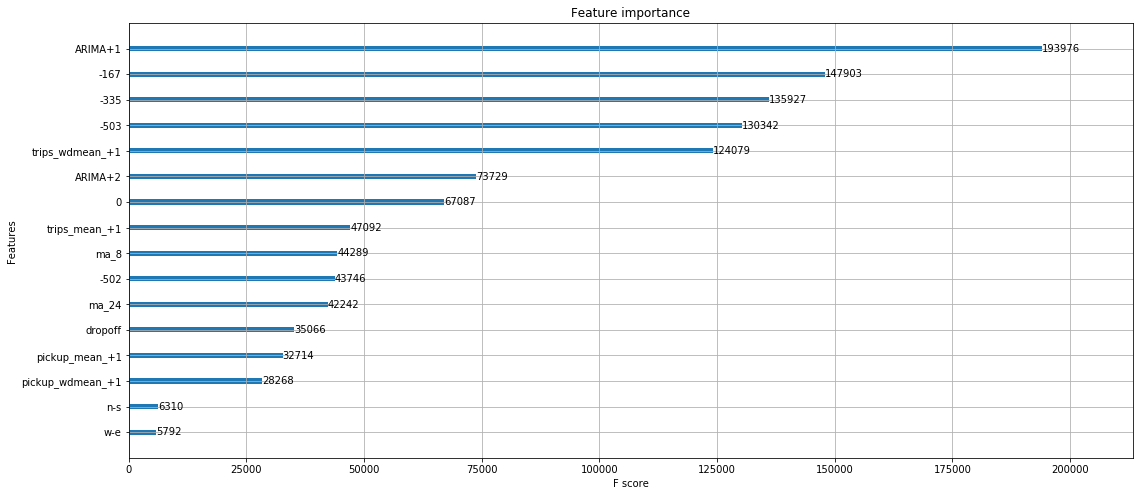

Модель со смещением в 2 ч.


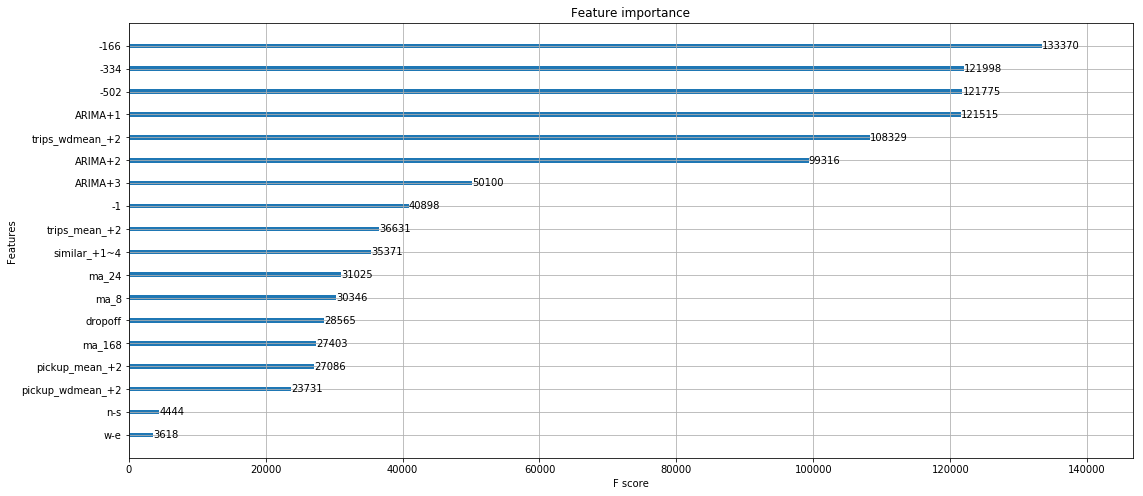

Модель со смещением в 3 ч.


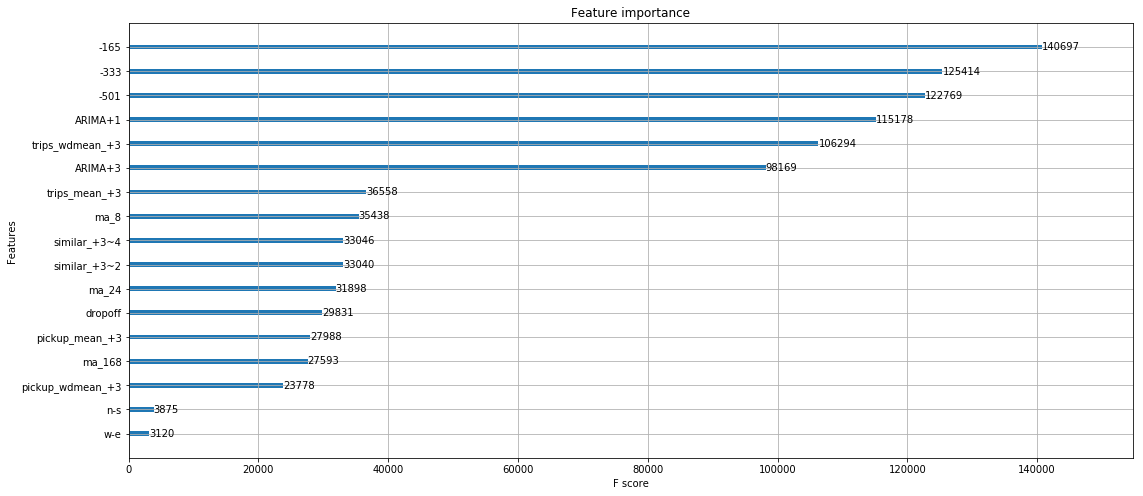

Модель со смещением в 4 ч.


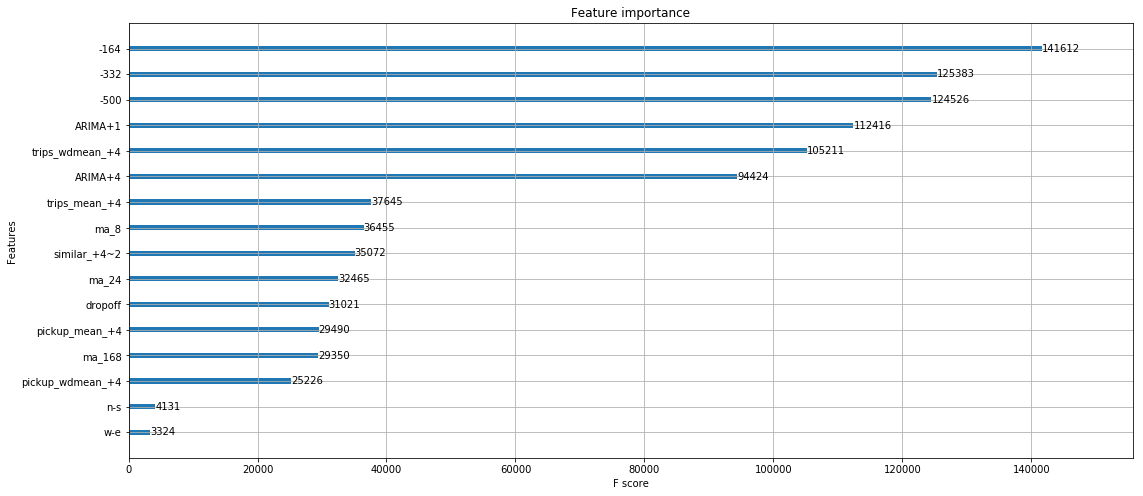

Модель со смещением в 5 ч.


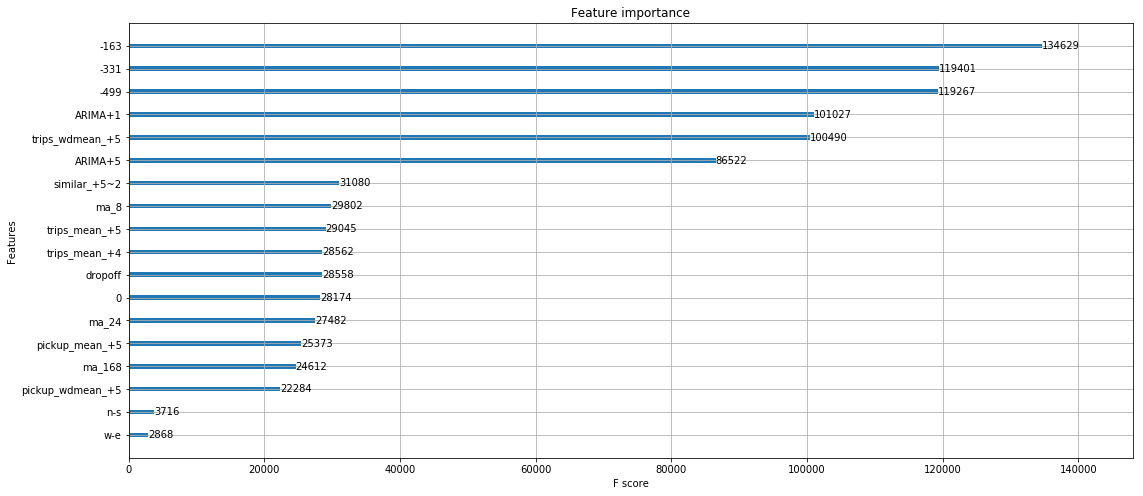

Модель со смещением в 6 ч.


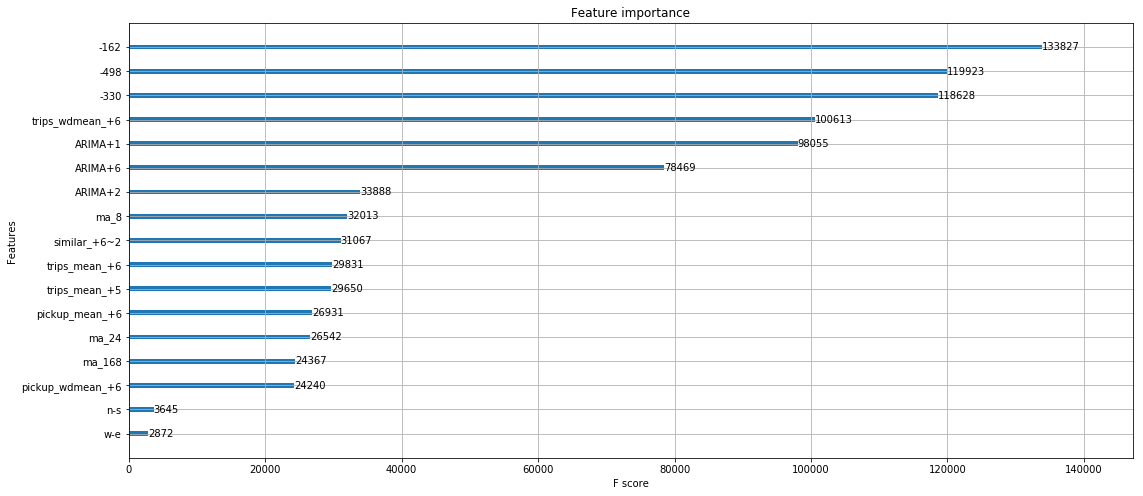

In [56]:
for shift, model in enumerate(best_general_model_load, 1):
    print('Модель со смещением в {} ч.'.format(shift))
    fig, ax = plt.subplots(figsize=(18,8))
    plot_importance(model, ax=ax)
    pyplot.show()

Результаты оценки прогнозов на тестовых данных за июнь 2016 можно посмотреть на странице сайта [Kaggle](https://www.kaggle.com) по ссылке [Жёлтое такси](https://inclass.kaggle.com/c/yellowtaxi/leaderboard), Team Name: Anton Frolenkov.